In [1]:
import torch
from torch.utils.data import Dataset
import pandas as pd

class FakeNewsDataset(Dataset):
    def __init__(self, mode, tokenizer, path):
        assert mode in ['train', 'val']
        self.mode = mode
        self.df = pd.read_csv(path + mode + '.tsv', sep='\t').fillna('')
        self.len = len(self.df)
        self.tokenizer = tokenizer # BERT tokenizer
        
    def __getitem__(self, idx):
        statement, label = self.df.iloc[idx, :].values
        label_tensor = torch.tensor(label)
            
        word_pieces = ['[CLS]']
        statement = self.tokenizer.tokenize(statement)
        word_pieces += statement + ['[SEP]']
        len_st = len(word_pieces)
            
        ids = self.tokenizer.convert_tokens_to_ids(word_pieces)
        tokens_tensor = torch.tensor(ids)
            
        segments_tensor = torch.tensor([0] * len_st, dtype=torch.long)
            
        return (tokens_tensor, segments_tensor, label_tensor)
        
    def __len__(self):
        return self.len

In [2]:
class FakeNewsDatasetLIAR(Dataset):
    def __init__(self, mode, tokenizer, path):
        assert mode in ['train', 'val']
        self.mode = mode
        self.df = pd.read_csv(path + mode + '.tsv', sep='\t').fillna('')
        self.len = len(self.df)
        self.tokenizer = tokenizer # BERT tokenizer
        
    def __getitem__(self, idx):
        label, statement = self.df.iloc[idx, :].values
        label_tensor = torch.tensor(label)
            
        word_pieces = ['[CLS]']
        statement = self.tokenizer.tokenize(statement)
        word_pieces += statement + ['[SEP]']
        len_st = len(word_pieces)
            
        ids = self.tokenizer.convert_tokens_to_ids(word_pieces)
        tokens_tensor = torch.tensor(ids)
            
        segments_tensor = torch.tensor([0] * len_st, dtype=torch.long)
            
        return (tokens_tensor, segments_tensor, label_tensor)
        
    def __len__(self):
        return self.len

In [3]:
# reforming the dataset to fit the model

from torch.utils.data import DataLoader
from torch.nn.utils.rnn import pad_sequence

def create_mini_batch(samples):
    tokens_tensors = [s[0] for s in samples]
    segments_tensors = [s[1] for s in samples]
    
    if samples[0][2] is not None:
        label_ids = torch.stack([s[2] for s in samples])
    else:
        label_ids = None
        
    # zero padding
    tokens_tensors = pad_sequence(tokens_tensors, batch_first=True)
    segments_tensors = pad_sequence(segments_tensors, batch_first=True)
    
    masks_tensors = torch.zeros(tokens_tensors.shape, dtype=torch.long)
    masks_tensors = masks_tensors.masked_fill(tokens_tensors != 0,1)
    
    return tokens_tensors, segments_tensors, masks_tensors, label_ids

BATCH_SIZE = 16

In [5]:
# model construction - replace BERT with another other pretrained model

from transformers import BertForSequenceClassification
from IPython.display import display, clear_output
from transformers import BertTokenizer

MODEL_NAME = 'bert-base-uncased'
tokenizer = BertTokenizer.from_pretrained(MODEL_NAME)

NUM_LABELS = 2

model = BertForSequenceClassification.from_pretrained(
        MODEL_NAME, num_labels=NUM_LABELS)

C:\Users\matti\anaconda3\lib\site-packages\huggingface_hub\file_download.py:133: UserWarning: `huggingface_hub` cache-system uses symlinks by default to efficiently store duplicated files but your machine does not support them in C:\Users\matti\.cache\huggingface\hub. Caching files will still work but in a degraded version that might require more space on your disk. This warning can be disabled by setting the `HF_HUB_DISABLE_SYMLINKS_WARNING` environment variable. For more details, see https://huggingface.co/docs/huggingface_hub/how-to-cache#limitations.
To support symlinks on Windows, you either need to activate Developer Mode or to run Python as an administrator. In order to see activate developer mode, see this article: https://docs.microsoft.com/en-us/windows/apps/get-started/enable-your-device-for-development
  warnings.warn(message)
Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertForSequenceClassification: ['cls.predictions.transform.

In [7]:
trainset = FakeNewsDataset('train', tokenizer=tokenizer, path='./')
trainloader = DataLoader(trainset, batch_size=BATCH_SIZE, collate_fn=create_mini_batch)

In [8]:
# fine-tuning of BERT

from sklearn.metrics import accuracy_score
from tqdm.notebook import tqdm

device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
print('device:', device)
model.to(device)

model.train()
optimizer = torch.optim.AdamW(model.parameters(), lr=1e-5)
NUM_EPOCHS = 10

for epoch in range(NUM_EPOCHS):
    train_loss = 0.0
    train_acc = 0.0
    
    loop = tqdm(trainloader)
    for batch_idx, data in enumerate(loop):
        tokens_tensors, segments_tensors, masks_tensors, labels = [t.to(device) for t in data]
        
        optimizer.zero_grad()
        
        outputs = model(input_ids=tokens_tensors,
                      token_type_ids=segments_tensors,
                      attention_mask=masks_tensors,
                      labels=labels)
        
        loss = outputs[0]
        loss.backward()
        optimizer.step()
        
        logits = outputs[1]
        _, pred = torch.max(logits.data, 1)
        train_acc = accuracy_score(pred.cpu().tolist(), labels.cpu().tolist())
        
        train_loss += loss.item()
        
        loop.set_description(f'Epoch [{epoch + 1}/{NUM_EPOCHS}]')
        loop.set_postfix(acc=train_acc, loss=train_loss/(batch_idx+1))

device: cuda:0


  0%|          | 0/2245 [00:00<?, ?it/s]

KeyboardInterrupt: 

In [ ]:
# save model
torch.save(model, 'BERT/best_model.pth')

In [18]:
# load model - ISOT BERT

# model = torch.load('BERT/best_model.pth')

# device = torch.device('cuda:0')
# model = model.to(device)

In [19]:
# load all valsets

valset_isot = FakeNewsDataset('val', tokenizer=tokenizer, path ='./')
print('isot valset size:', valset_isot.__len__())

valset_liar = FakeNewsDatasetLIAR('val', tokenizer=tokenizer, path ='../D2/')
print('liar valset size:', valset_liar.__len__())

valset_fnd = FakeNewsDataset('val', tokenizer=tokenizer, path ='../D3/')
print('fnd valset size:', valset_fnd.__len__())

valset_fnn = FakeNewsDataset('val', tokenizer=tokenizer, path='../D4/')
print('fnn valset size:', valset_fnn.__len__())

valset_covid = FakeNewsDataset('val', tokenizer=tokenizer, path ='../D5/')
print('covid valset size:', valset_covid.__len__())

isot valset size: 8980
liar valset size: 1588
fnd valset size: 4048
fnn valset size: 4639
covid valset size: 624


In [23]:
# create all valloaders

valloader_isot = DataLoader(valset_isot, batch_size=BATCH_SIZE, collate_fn=create_mini_batch)
valloader_liar = DataLoader(valset_liar, batch_size=BATCH_SIZE, collate_fn=create_mini_batch)
valloader_fnd = DataLoader(valset_fnd, batch_size=BATCH_SIZE, collate_fn=create_mini_batch)
valloader_fnn = DataLoader(valset_fnn, batch_size=BATCH_SIZE, collate_fn=create_mini_batch)
valloader_covid = DataLoader(valset_covid, batch_size=BATCH_SIZE, collate_fn=create_mini_batch)

In [26]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.metrics import f1_score

def evaluate(valloader):
    true = []
    predictions = []
    with torch.no_grad():
        model.eval()
        for data in valloader:
            if next(model.parameters()).is_cuda:
                data = [t.to(device) for t in data if t is not None]

            tokens_tensors, segments_tensors, masks_tensors = data[:3]
            val_outputs = model(input_ids=tokens_tensors,
                               token_type_ids=segments_tensors,
                               attention_mask=masks_tensors)

            logits = val_outputs[0]
            _, pred = torch.max(logits.data, 1)

            labels = data[3]
            true.extend(labels.cpu().tolist())
            predictions.extend(pred.cpu().tolist())

    cm = confusion_matrix(true, predictions, labels=[1, 0], normalize='pred')
    print(cm)

    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['Real', 'Fake'])
    disp.plot()

    print('F1 Score: ', f1_score(true, predictions))
    print()

ISOT:
[[0.9809502  0.00648929]
 [0.0190498  0.99351071]]
F1 Score:  0.9869530077358272

LIAR:
[[0.50724638 0.560477  ]
 [0.49275362 0.439523  ]]
F1 Score:  0.32761310452418096

Fake News Dataset:
[[0.33352144 0.58963093]
 [0.66647856 0.41036907]]
F1 Score:  0.31902834008097164

Fake News Net:
[[0.80887574 0.70532384]
 [0.19112426 0.29467616]]
F1 Score:  0.5322172474206734

Covid-19 Fake News:
[[0.69323671 0.4952381 ]
 [0.30676329 0.5047619 ]]
F1 Score:  0.7130434782608697



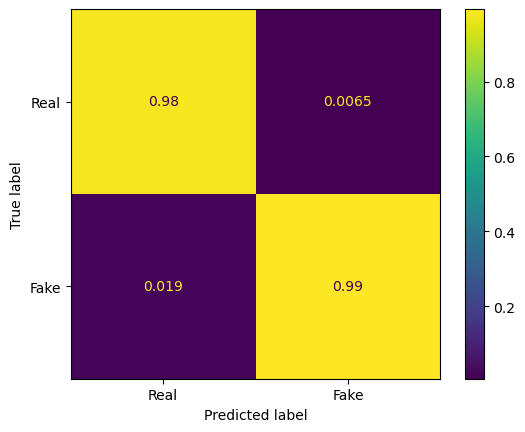

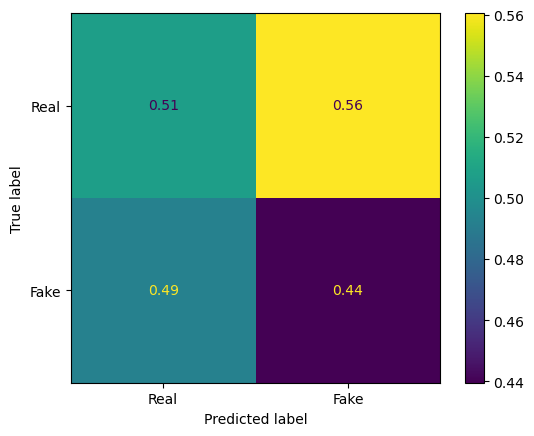

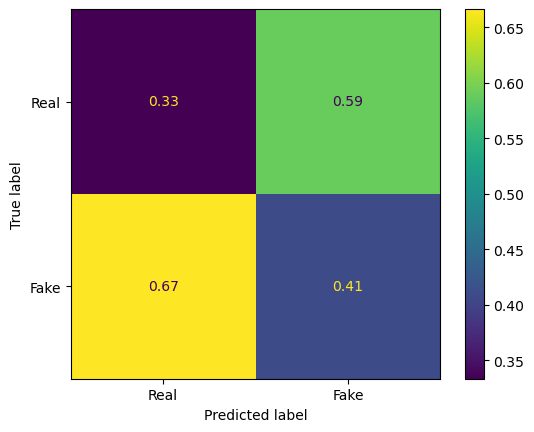

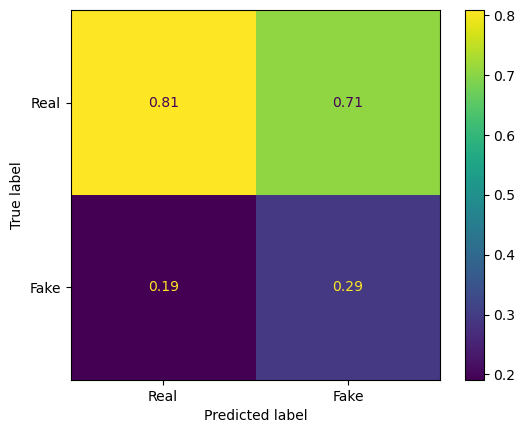

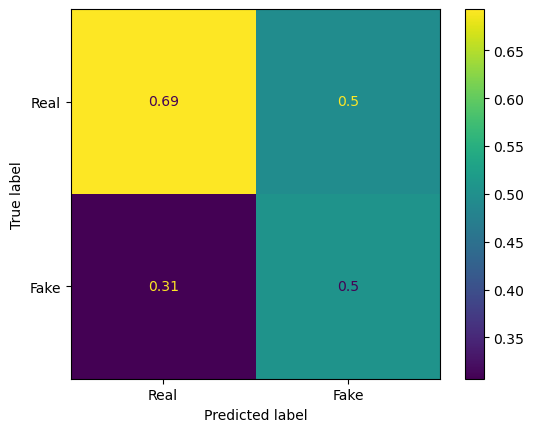

In [27]:
# evaluate model out of distribution

print('ISOT:')
evaluate(valloader_isot)

print('LIAR:')
evaluate(valloader_liar)

print('Fake News Dataset:')
evaluate(valloader_fnd)

print('Fake News Net:')
evaluate(valloader_fnn)

print('Covid-19 Fake News:')
evaluate(valloader_covid)